In [6]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
%pylab inline

import librosa
import librosa.display
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

Populating the interactive namespace from numpy and matplotlib


In [7]:
# importing labels of the files
labels = os.listdir("Data/")

In [8]:
labels[5]

'03-01-02-01-01-01-06.wav'

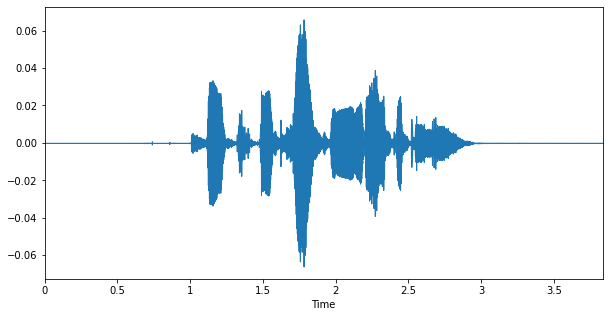

In [10]:
data, sampling_rate = librosa.load(f"Data/{labels[1]}")

plt.figure(figsize=(10,5))
librosa.display.waveplot(data, sr=sampling_rate);

## Extract emotions

In [13]:
emotions = np.array([label.split("-")[2] for label in labels])

In [16]:
emotions[:5]

array(['02', '02', '02', '02', '02'], dtype='<U2')

In [17]:
def extract_features(filename):
    audio, sample_rate = librosa.load(filename, res_type="kaiser_fast")
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [19]:
features = []

for label in labels:
    filename = f"Data/{label}"
    
    emotion = label.split("-")[2]
    data = extract_features(filename)
    features.append([data, emotion])

In [22]:
features[1]

[array([-6.66113403e+02,  5.62173576e+01, -7.56887484e+00,  1.57707405e+01,
        -8.45027637e+00,  1.83744097e+00, -6.82167864e+00, -4.37701273e+00,
        -5.91381168e+00,  5.17688990e-01, -5.59894037e+00, -2.13708138e+00,
        -6.38166094e+00,  2.84868383e+00, -6.89996719e+00, -1.23033297e+00,
        -4.16035271e+00, -1.37664831e+00, -4.97348595e+00, -1.35401809e+00,
        -2.00252700e+00, -2.14882398e+00, -1.11055171e+00, -2.46265188e-01,
        -1.22439280e-01,  4.77262735e-01,  4.27485657e+00,  4.82439423e+00,
         7.54139376e+00,  4.93660450e+00,  3.66524744e+00,  3.25066614e+00,
         2.14365625e+00,  3.23849964e+00,  2.43824267e+00,  2.52844048e+00,
        -3.09295207e-01,  9.82488215e-01,  1.01983917e+00,  5.99840820e-01],
       dtype=float32),
 '02']

In [24]:
features_df = pd.DataFrame(features, columns=["feature", "emotion"])

In [25]:
features_df.head()

,feature,emotion
0,"[-729.98016, 66.51589, -0.9419843, 19.070974, ...",02
1,"[-666.1134, 56.217358, -7.568875, 15.7707405, ...",02
2,"[-639.27637, 69.9923, 0.7942198, 17.575535, 1....",02
3,"[-663.54083, 56.19745, -15.152023, 8.111385, -...",02
4,"[-734.74243, 77.852264, 6.6088023, 23.579966, ...",02


In [26]:
### Split the dataset into independent and dependent dataset
X=np.array(features_df['feature'].tolist())
y=np.array(features_df['emotion'].tolist())

In [28]:
X.shape, y.shape

((960, 40), (960,))

In [30]:
y[:10]

array(['02', '02', '02', '02', '02', '02', '02', '02', '02', '02'],
      dtype='<U2')

In [31]:
### Label Encoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [34]:
y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [35]:
### Train Test Split
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [36]:
X_train

array([[-6.9474713e+02,  5.5160381e+01, -2.5127358e+00, ...,
        -7.3903787e-01, -1.9837615e+00, -1.2665052e+00],
       [-8.0673053e+02,  4.5237591e+01, -5.5813923e+00, ...,
         2.7756355e+00,  5.9816724e-01,  5.2687460e-01],
       [-6.1684766e+02,  8.1195053e+01, -6.6228852e+00, ...,
         2.4592552e+00, -1.2701117e+00, -6.9109130e-01],
       ...,
       [-5.8245581e+02,  4.5947723e+01, -2.5991879e+01, ...,
        -7.8162730e-01,  1.3410363e+00,  1.9998642e+00],
       [-6.3795978e+02,  7.1686310e+01, -6.8877344e+00, ...,
         4.0222698e-01, -1.3108990e+00,  5.2045202e-01],
       [-3.6642828e+02,  2.3118233e+01, -1.6935003e+01, ...,
         2.2547913e-01,  1.0447268e+00,  3.1393673e+00]], dtype=float32)

In [37]:
y_train

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [38]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((768, 40), (768, 5), (192, 40), (192, 5))

## Model Creation

In [39]:
### No of classes
num_labels=y.shape[1]

In [40]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4100      
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 activation_1 (Activation)   (None, 200)               0         
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               2

In [42]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [59]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint

num_epochs = 700
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='./saveModel/audio_classification2.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


Epoch 1/700
 1/24 [>.............................] - ETA: 0s - loss: 0.9714 - accuracy: 0.6250
Epoch 00001: val_loss improved from inf to 0.97130, saving model to ./saveModel\audio_classification2.hdf5
24/24 [==============================] - 0s 8ms/step - loss: 0.7554 - accuracy: 0.7018 - val_loss: 0.9713 - val_accuracy: 0.6302
Epoch 2/700
 1/24 [>.............................] - ETA: 0s - loss: 0.9551 - accuracy: 0.5625
Epoch 00002: val_loss did not improve from 0.97130
24/24 [==============================] - 0s 2ms/step - loss: 0.7618 - accuracy: 0.6836 - val_loss: 1.0635 - val_accuracy: 0.6042
Epoch 3/700
 1/24 [>.............................] - ETA: 0s - loss: 0.8442 - accuracy: 0.6875
Epoch 00003: val_loss did not improve from 0.97130
24/24 [==============================] - 0s 2ms/step - loss: 0.7392 - accuracy: 0.7057 - val_loss: 0.9809 - val_accuracy: 0.6146
Epoch 4/700
 1/24 [>.............................] - ETA: 0s - loss: 0.8998 - accuracy: 0.7500
Epoch 00004: val_loss im

 1/24 [>.............................] - ETA: 0s - loss: 0.6074 - accuracy: 0.7500
Epoch 00030: val_loss did not improve from 0.89037
24/24 [==============================] - 0s 2ms/step - loss: 0.7016 - accuracy: 0.7201 - val_loss: 1.0092 - val_accuracy: 0.5990
Epoch 31/700
 1/24 [>.............................] - ETA: 0s - loss: 0.4479 - accuracy: 0.7812
Epoch 00031: val_loss did not improve from 0.89037
24/24 [==============================] - 0s 3ms/step - loss: 0.7120 - accuracy: 0.7292 - val_loss: 1.0581 - val_accuracy: 0.5833
Epoch 32/700
 1/24 [>.............................] - ETA: 0s - loss: 0.6462 - accuracy: 0.7500
Epoch 00032: val_loss did not improve from 0.89037
24/24 [==============================] - 0s 3ms/step - loss: 0.7538 - accuracy: 0.7109 - val_loss: 0.9393 - val_accuracy: 0.6302
Epoch 33/700
 1/24 [>.............................] - ETA: 0s - loss: 0.6256 - accuracy: 0.7500
Epoch 00033: val_loss did not improve from 0.89037
24/24 [==============================]

 1/24 [>.............................] - ETA: 0s - loss: 0.7411 - accuracy: 0.6562
Epoch 00059: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.7059 - accuracy: 0.7018 - val_loss: 0.9496 - val_accuracy: 0.6146
Epoch 60/700
 1/24 [>.............................] - ETA: 0s - loss: 0.6216 - accuracy: 0.7812
Epoch 00060: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.7278 - accuracy: 0.7083 - val_loss: 0.9541 - val_accuracy: 0.6094
Epoch 61/700
 1/24 [>.............................] - ETA: 0s - loss: 0.8548 - accuracy: 0.7812
Epoch 00061: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.7406 - accuracy: 0.7357 - val_loss: 0.9867 - val_accuracy: 0.5990
Epoch 62/700
 1/24 [>.............................] - ETA: 0s - loss: 0.7650 - accuracy: 0.6250
Epoch 00062: val_loss did not improve from 0.88313
24/24 [==============================]

Epoch 89/700
 1/24 [>.............................] - ETA: 0s - loss: 0.7471 - accuracy: 0.6562
Epoch 00089: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.6633 - accuracy: 0.7227 - val_loss: 1.0204 - val_accuracy: 0.5885
Epoch 90/700
 1/24 [>.............................] - ETA: 0s - loss: 0.7825 - accuracy: 0.6875
Epoch 00090: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.8090 - accuracy: 0.6797 - val_loss: 0.9647 - val_accuracy: 0.5990
Epoch 91/700
 1/24 [>.............................] - ETA: 0s - loss: 0.7768 - accuracy: 0.6250
Epoch 00091: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.7505 - accuracy: 0.6966 - val_loss: 1.0031 - val_accuracy: 0.5938
Epoch 92/700
21/24 [=========================>....] - ETA: 0s - loss: 0.6796 - accuracy: 0.7232
Epoch 00092: val_loss did not improve from 0.88313
24/24 [==================

Epoch 119/700
 1/24 [>.............................] - ETA: 0s - loss: 0.3841 - accuracy: 0.8125
Epoch 00119: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.7101 - accuracy: 0.7005 - val_loss: 1.0111 - val_accuracy: 0.6146
Epoch 120/700
 1/24 [>.............................] - ETA: 0s - loss: 0.6312 - accuracy: 0.7500
Epoch 00120: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 3ms/step - loss: 0.7153 - accuracy: 0.7044 - val_loss: 1.0785 - val_accuracy: 0.6302
Epoch 121/700
 1/24 [>.............................] - ETA: 0s - loss: 0.7838 - accuracy: 0.7188
Epoch 00121: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.7106 - accuracy: 0.7174 - val_loss: 1.0524 - val_accuracy: 0.5990
Epoch 122/700
 1/24 [>.............................] - ETA: 0s - loss: 0.6071 - accuracy: 0.7188
Epoch 00122: val_loss did not improve from 0.88313
24/24 [==============

Epoch 149/700
 1/24 [>.............................] - ETA: 0s - loss: 0.8375 - accuracy: 0.6250
Epoch 00149: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 3ms/step - loss: 0.7016 - accuracy: 0.7174 - val_loss: 0.9659 - val_accuracy: 0.5990
Epoch 150/700
 1/24 [>.............................] - ETA: 0s - loss: 0.5552 - accuracy: 0.7500
Epoch 00150: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.7487 - val_loss: 1.1340 - val_accuracy: 0.5885
Epoch 151/700
 1/24 [>.............................] - ETA: 0s - loss: 0.7600 - accuracy: 0.7500
Epoch 00151: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.7050 - accuracy: 0.7057 - val_loss: 1.0822 - val_accuracy: 0.6250
Epoch 152/700
 1/24 [>.............................] - ETA: 0s - loss: 0.7280 - accuracy: 0.7188
Epoch 00152: val_loss did not improve from 0.88313
24/24 [==============

Epoch 179/700
 1/24 [>.............................] - ETA: 0s - loss: 0.5659 - accuracy: 0.7500
Epoch 00179: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.7529 - accuracy: 0.6901 - val_loss: 1.0374 - val_accuracy: 0.5781
Epoch 180/700
 1/24 [>.............................] - ETA: 0s - loss: 0.9515 - accuracy: 0.6875
Epoch 00180: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.7837 - accuracy: 0.6914 - val_loss: 1.0085 - val_accuracy: 0.5833
Epoch 181/700
 1/24 [>.............................] - ETA: 0s - loss: 0.8836 - accuracy: 0.6250
Epoch 00181: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.7330 - accuracy: 0.6823 - val_loss: 1.0590 - val_accuracy: 0.6146
Epoch 182/700
 1/24 [>.............................] - ETA: 0s - loss: 0.5838 - accuracy: 0.6875
Epoch 00182: val_loss did not improve from 0.88313
24/24 [==============

Epoch 209/700
 1/24 [>.............................] - ETA: 0s - loss: 0.8199 - accuracy: 0.6562
Epoch 00209: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.7443 - accuracy: 0.7070 - val_loss: 1.0602 - val_accuracy: 0.5781
Epoch 210/700
 1/24 [>.............................] - ETA: 0s - loss: 0.6511 - accuracy: 0.8750
Epoch 00210: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.7001 - accuracy: 0.7161 - val_loss: 1.1190 - val_accuracy: 0.6094
Epoch 211/700
 1/24 [>.............................] - ETA: 0s - loss: 0.6834 - accuracy: 0.8125
Epoch 00211: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.7427 - accuracy: 0.6836 - val_loss: 1.0405 - val_accuracy: 0.5781
Epoch 212/700
 1/24 [>.............................] - ETA: 0s - loss: 1.0338 - accuracy: 0.5938
Epoch 00212: val_loss did not improve from 0.88313
24/24 [==============

Epoch 239/700
 1/24 [>.............................] - ETA: 0s - loss: 0.7776 - accuracy: 0.5625
Epoch 00239: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.6948 - accuracy: 0.7122 - val_loss: 1.0605 - val_accuracy: 0.6146
Epoch 240/700
 1/24 [>.............................] - ETA: 0s - loss: 1.4929 - accuracy: 0.6562
Epoch 00240: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 3ms/step - loss: 0.7009 - accuracy: 0.7096 - val_loss: 1.0984 - val_accuracy: 0.5990
Epoch 241/700
 1/24 [>.............................] - ETA: 0s - loss: 0.6760 - accuracy: 0.6875
Epoch 00241: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.7222 - accuracy: 0.7057 - val_loss: 1.1250 - val_accuracy: 0.5990
Epoch 242/700
 1/24 [>.............................] - ETA: 0s - loss: 0.7307 - accuracy: 0.6562
Epoch 00242: val_loss did not improve from 0.88313
24/24 [==============

Epoch 269/700
 1/24 [>.............................] - ETA: 0s - loss: 0.8662 - accuracy: 0.5625
Epoch 00269: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.7553 - accuracy: 0.6836 - val_loss: 1.0383 - val_accuracy: 0.6094
Epoch 270/700
 1/24 [>.............................] - ETA: 0s - loss: 0.6527 - accuracy: 0.7188
Epoch 00270: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.7212 - accuracy: 0.6979 - val_loss: 1.0400 - val_accuracy: 0.5781
Epoch 271/700
 1/24 [>.............................] - ETA: 0s - loss: 0.6448 - accuracy: 0.5625
Epoch 00271: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.7929 - accuracy: 0.6797 - val_loss: 1.0675 - val_accuracy: 0.6302
Epoch 272/700
 1/24 [>.............................] - ETA: 0s - loss: 0.8787 - accuracy: 0.5312
Epoch 00272: val_loss did not improve from 0.88313
24/24 [==============

Epoch 299/700
18/24 [=====================>........] - ETA: 0s - loss: 0.8347 - accuracy: 0.6701
Epoch 00299: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 4ms/step - loss: 0.8303 - accuracy: 0.6654 - val_loss: 1.0229 - val_accuracy: 0.5990
Epoch 300/700
21/24 [=========================>....] - ETA: 0s - loss: 0.8163 - accuracy: 0.6607
Epoch 00300: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 7ms/step - loss: 0.8156 - accuracy: 0.6602 - val_loss: 0.9834 - val_accuracy: 0.5885
Epoch 301/700
18/24 [=====================>........] - ETA: 0s - loss: 0.7299 - accuracy: 0.6927
Epoch 00301: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 6ms/step - loss: 0.7676 - accuracy: 0.6875 - val_loss: 1.0387 - val_accuracy: 0.6198
Epoch 302/700
24/24 [==============================] - ETA: 0s - loss: 0.7530 - accuracy: 0.7018
Epoch 00302: val_loss did not improve from 0.88313
24/24 [==============

Epoch 329/700
 1/24 [>.............................] - ETA: 0s - loss: 0.7137 - accuracy: 0.7188
Epoch 00329: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.6553 - accuracy: 0.7409 - val_loss: 1.0374 - val_accuracy: 0.6406
Epoch 330/700
 1/24 [>.............................] - ETA: 0s - loss: 0.5395 - accuracy: 0.8438
Epoch 00330: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.7461 - val_loss: 1.0362 - val_accuracy: 0.6198
Epoch 331/700
 1/24 [>.............................] - ETA: 0s - loss: 0.7115 - accuracy: 0.6875
Epoch 00331: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 3ms/step - loss: 0.7468 - accuracy: 0.6927 - val_loss: 1.0842 - val_accuracy: 0.5990
Epoch 332/700
 1/24 [>.............................] - ETA: 0s - loss: 0.5534 - accuracy: 0.7500
Epoch 00332: val_loss did not improve from 0.88313
24/24 [==============

Epoch 359/700
 1/24 [>.............................] - ETA: 0s - loss: 0.9307 - accuracy: 0.6562
Epoch 00359: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.7334 - accuracy: 0.7122 - val_loss: 1.1498 - val_accuracy: 0.6146
Epoch 360/700
 1/24 [>.............................] - ETA: 0s - loss: 0.6579 - accuracy: 0.7188
Epoch 00360: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 3ms/step - loss: 0.7215 - accuracy: 0.7070 - val_loss: 1.1229 - val_accuracy: 0.5938
Epoch 361/700
 1/24 [>.............................] - ETA: 0s - loss: 0.5805 - accuracy: 0.7500
Epoch 00361: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 3ms/step - loss: 0.7642 - accuracy: 0.6771 - val_loss: 1.1439 - val_accuracy: 0.5990
Epoch 362/700
 1/24 [>.............................] - ETA: 0s - loss: 0.6739 - accuracy: 0.7188
Epoch 00362: val_loss did not improve from 0.88313
24/24 [==============

Epoch 389/700
 1/24 [>.............................] - ETA: 0s - loss: 0.6531 - accuracy: 0.7500
Epoch 00389: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.7096 - val_loss: 1.1214 - val_accuracy: 0.6198
Epoch 390/700
 1/24 [>.............................] - ETA: 0s - loss: 0.8007 - accuracy: 0.5938
Epoch 00390: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.6970 - accuracy: 0.7018 - val_loss: 1.0942 - val_accuracy: 0.6146
Epoch 391/700
 1/24 [>.............................] - ETA: 0s - loss: 0.5318 - accuracy: 0.7188
Epoch 00391: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.7376 - accuracy: 0.6888 - val_loss: 1.0665 - val_accuracy: 0.6198
Epoch 392/700
 1/24 [>.............................] - ETA: 0s - loss: 0.6270 - accuracy: 0.8125
Epoch 00392: val_loss did not improve from 0.88313
24/24 [==============

Epoch 419/700
 1/24 [>.............................] - ETA: 0s - loss: 0.8633 - accuracy: 0.7188
Epoch 00419: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 3ms/step - loss: 0.7115 - accuracy: 0.7161 - val_loss: 1.0902 - val_accuracy: 0.6302
Epoch 420/700
 1/24 [>.............................] - ETA: 0s - loss: 0.8772 - accuracy: 0.5938
Epoch 00420: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.6941 - accuracy: 0.6953 - val_loss: 1.1371 - val_accuracy: 0.5990
Epoch 421/700
 1/24 [>.............................] - ETA: 0s - loss: 0.6293 - accuracy: 0.7812
Epoch 00421: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.6839 - accuracy: 0.7161 - val_loss: 1.1370 - val_accuracy: 0.6198
Epoch 422/700
 1/24 [>.............................] - ETA: 0s - loss: 0.8553 - accuracy: 0.6250
Epoch 00422: val_loss did not improve from 0.88313
24/24 [==============

Epoch 449/700
 1/24 [>.............................] - ETA: 0s - loss: 0.6060 - accuracy: 0.8125
Epoch 00449: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 3ms/step - loss: 0.6617 - accuracy: 0.7227 - val_loss: 1.1684 - val_accuracy: 0.6302
Epoch 450/700
 1/24 [>.............................] - ETA: 0s - loss: 0.7413 - accuracy: 0.7812
Epoch 00450: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.7422 - val_loss: 1.0619 - val_accuracy: 0.6198
Epoch 451/700
 1/24 [>.............................] - ETA: 0s - loss: 0.6808 - accuracy: 0.7188
Epoch 00451: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.6887 - accuracy: 0.7201 - val_loss: 1.1637 - val_accuracy: 0.6094
Epoch 452/700
 1/24 [>.............................] - ETA: 0s - loss: 0.5224 - accuracy: 0.7500
Epoch 00452: val_loss did not improve from 0.88313
24/24 [==============

Epoch 479/700
 1/24 [>.............................] - ETA: 0s - loss: 0.4795 - accuracy: 0.8125
Epoch 00479: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.7064 - accuracy: 0.7096 - val_loss: 0.9991 - val_accuracy: 0.6198
Epoch 480/700
 1/24 [>.............................] - ETA: 0s - loss: 0.5842 - accuracy: 0.7500
Epoch 00480: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.6918 - accuracy: 0.7096 - val_loss: 1.0067 - val_accuracy: 0.5938
Epoch 481/700
 1/24 [>.............................] - ETA: 0s - loss: 0.6341 - accuracy: 0.7500
Epoch 00481: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.7497 - accuracy: 0.6914 - val_loss: 1.0976 - val_accuracy: 0.6354
Epoch 482/700
 1/24 [>.............................] - ETA: 0s - loss: 0.6879 - accuracy: 0.7500
Epoch 00482: val_loss did not improve from 0.88313
24/24 [==============

Epoch 509/700
 1/24 [>.............................] - ETA: 0s - loss: 0.6895 - accuracy: 0.6875
Epoch 00509: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 3ms/step - loss: 0.6671 - accuracy: 0.7201 - val_loss: 1.0255 - val_accuracy: 0.6198
Epoch 510/700
 1/24 [>.............................] - ETA: 0s - loss: 0.7207 - accuracy: 0.6562
Epoch 00510: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 3ms/step - loss: 0.6834 - accuracy: 0.7240 - val_loss: 1.1379 - val_accuracy: 0.5990
Epoch 511/700
 1/24 [>.............................] - ETA: 0s - loss: 0.6200 - accuracy: 0.7500
Epoch 00511: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 3ms/step - loss: 0.6741 - accuracy: 0.7227 - val_loss: 1.2007 - val_accuracy: 0.5990
Epoch 512/700
 1/24 [>.............................] - ETA: 0s - loss: 0.8705 - accuracy: 0.5625
Epoch 00512: val_loss did not improve from 0.88313
24/24 [==============

Epoch 539/700
 1/24 [>.............................] - ETA: 0s - loss: 0.7337 - accuracy: 0.6250
Epoch 00539: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 3ms/step - loss: 0.7872 - accuracy: 0.6706 - val_loss: 1.0576 - val_accuracy: 0.5885
Epoch 540/700
 1/24 [>.............................] - ETA: 0s - loss: 0.7472 - accuracy: 0.6562
Epoch 00540: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 3ms/step - loss: 0.8124 - accuracy: 0.6497 - val_loss: 1.0723 - val_accuracy: 0.5885
Epoch 541/700
 1/24 [>.............................] - ETA: 0s - loss: 0.9715 - accuracy: 0.5312
Epoch 00541: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.7533 - accuracy: 0.6797 - val_loss: 1.1834 - val_accuracy: 0.5729
Epoch 542/700
 1/24 [>.............................] - ETA: 0s - loss: 0.8337 - accuracy: 0.7500
Epoch 00542: val_loss did not improve from 0.88313
24/24 [==============

Epoch 569/700
11/24 [============>.................] - ETA: 0s - loss: 0.7056 - accuracy: 0.7188
Epoch 00569: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 4ms/step - loss: 0.7109 - accuracy: 0.7240 - val_loss: 1.2127 - val_accuracy: 0.5990
Epoch 570/700
 1/24 [>.............................] - ETA: 0s - loss: 0.7231 - accuracy: 0.6250
Epoch 00570: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.7214 - accuracy: 0.7096 - val_loss: 1.1246 - val_accuracy: 0.6406
Epoch 571/700
 1/24 [>.............................] - ETA: 0s - loss: 0.8031 - accuracy: 0.6875
Epoch 00571: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.7008 - accuracy: 0.7057 - val_loss: 1.1465 - val_accuracy: 0.5938
Epoch 572/700
 1/24 [>.............................] - ETA: 0s - loss: 0.6703 - accuracy: 0.7500
Epoch 00572: val_loss did not improve from 0.88313
24/24 [==============

Epoch 599/700
 1/24 [>.............................] - ETA: 0s - loss: 0.8907 - accuracy: 0.6562
Epoch 00599: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.7369 - accuracy: 0.6862 - val_loss: 1.1596 - val_accuracy: 0.5833
Epoch 600/700
 1/24 [>.............................] - ETA: 0s - loss: 0.7264 - accuracy: 0.6875
Epoch 00600: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.7207 - accuracy: 0.7096 - val_loss: 1.0980 - val_accuracy: 0.6094
Epoch 601/700
 1/24 [>.............................] - ETA: 0s - loss: 0.8959 - accuracy: 0.5938
Epoch 00601: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.6862 - accuracy: 0.7148 - val_loss: 1.1561 - val_accuracy: 0.6146
Epoch 602/700
 1/24 [>.............................] - ETA: 0s - loss: 0.7451 - accuracy: 0.6875
Epoch 00602: val_loss did not improve from 0.88313
24/24 [==============

Epoch 629/700
 1/24 [>.............................] - ETA: 0s - loss: 0.4295 - accuracy: 0.8125
Epoch 00629: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.6636 - accuracy: 0.7266 - val_loss: 1.1337 - val_accuracy: 0.5938
Epoch 630/700
 1/24 [>.............................] - ETA: 0s - loss: 0.9906 - accuracy: 0.5938
Epoch 00630: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.7445 - accuracy: 0.6888 - val_loss: 1.2127 - val_accuracy: 0.5938
Epoch 631/700
 1/24 [>.............................] - ETA: 0s - loss: 0.5653 - accuracy: 0.8438
Epoch 00631: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.7364 - accuracy: 0.7005 - val_loss: 1.1036 - val_accuracy: 0.5625
Epoch 632/700
 1/24 [>.............................] - ETA: 0s - loss: 0.7818 - accuracy: 0.6562
Epoch 00632: val_loss did not improve from 0.88313
24/24 [==============

Epoch 659/700
 1/24 [>.............................] - ETA: 0s - loss: 0.6755 - accuracy: 0.7500
Epoch 00659: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.7069 - accuracy: 0.7096 - val_loss: 1.2289 - val_accuracy: 0.5990
Epoch 660/700
 1/24 [>.............................] - ETA: 0s - loss: 0.7846 - accuracy: 0.6562
Epoch 00660: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.7230 - accuracy: 0.7018 - val_loss: 1.0377 - val_accuracy: 0.6042
Epoch 661/700
 1/24 [>.............................] - ETA: 0s - loss: 0.7024 - accuracy: 0.7500
Epoch 00661: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.7555 - accuracy: 0.6940 - val_loss: 1.1433 - val_accuracy: 0.6042
Epoch 662/700
 1/24 [>.............................] - ETA: 0s - loss: 0.8615 - accuracy: 0.6875
Epoch 00662: val_loss did not improve from 0.88313
24/24 [==============

Epoch 689/700
 1/24 [>.............................] - ETA: 0s - loss: 0.7055 - accuracy: 0.7188
Epoch 00689: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.7340 - accuracy: 0.7044 - val_loss: 1.1782 - val_accuracy: 0.6146
Epoch 690/700
 1/24 [>.............................] - ETA: 0s - loss: 0.6667 - accuracy: 0.7188
Epoch 00690: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.6905 - accuracy: 0.7109 - val_loss: 1.1930 - val_accuracy: 0.6042
Epoch 691/700
 1/24 [>.............................] - ETA: 0s - loss: 0.6353 - accuracy: 0.7500
Epoch 00691: val_loss did not improve from 0.88313
24/24 [==============================] - 0s 2ms/step - loss: 0.6966 - accuracy: 0.7174 - val_loss: 1.1802 - val_accuracy: 0.5938
Epoch 692/700
 1/24 [>.............................] - ETA: 0s - loss: 0.6863 - accuracy: 0.8125
Epoch 00692: val_loss did not improve from 0.88313
24/24 [==============

In [60]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
test_accuracy[1]

0.6197916865348816

In [64]:
model_imported = tf.keras.models.load_model("saveModel/audio_classification2.hdf5")

test_accuracy=model_imported.evaluate(X_test,y_test,verbose=0)
test_accuracy[1]

0.640625

In [65]:
model_imported2 = tf.keras.models.load_model("saveModel/audio_classification.hdf5")

test_accuracy=model_imported2.evaluate(X_test,y_test,verbose=0)
test_accuracy[1]

0.9010416865348816

In [66]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))

model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [68]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint

num_epochs = 200
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='./saveModel/audio_classification3.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


Epoch 1/200
21/24 [=========================>....] - ETA: 0s - loss: 0.0399 - accuracy: 0.9926
Epoch 00001: val_loss improved from inf to 1.55981, saving model to ./saveModel\audio_classification3.hdf5
24/24 [==============================] - 1s 27ms/step - loss: 0.0366 - accuracy: 0.9935 - val_loss: 1.5598 - val_accuracy: 0.7344
Epoch 2/200
21/24 [=========================>....] - ETA: 0s - loss: 0.0111 - accuracy: 0.9940
Epoch 00002: val_loss did not improve from 1.55981
24/24 [==============================] - 0s 17ms/step - loss: 0.0126 - accuracy: 0.9922 - val_loss: 1.9216 - val_accuracy: 0.7083
Epoch 3/200
22/24 [==========================>...] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000 ETA: 0s - loss: 0.0044 - accuracy: 1.
Epoch 00003: val_loss did not improve from 1.55981
24/24 [==============================] - 1s 24ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 1.7915 - val_accuracy: 0.7292
Epoch 4/200
21/24 [=========================>....] - ETA: 0s - loss: 0.0026 - 

Epoch 30/200
21/24 [=========================>....] - ETA: 0s - loss: 8.8849e-05 - accuracy: 1.0000
Epoch 00030: val_loss did not improve from 1.55981
24/24 [==============================] - 0s 19ms/step - loss: 8.1586e-05 - accuracy: 1.0000 - val_loss: 1.5901 - val_accuracy: 0.7500
Epoch 31/200
23/24 [===========================>..] - ETA: 0s - loss: 1.2909e-04 - accuracy: 1.0000
Epoch 00031: val_loss did not improve from 1.55981
24/24 [==============================] - 0s 20ms/step - loss: 1.2496e-04 - accuracy: 1.0000 - val_loss: 1.5977 - val_accuracy: 0.7500
Epoch 32/200
24/24 [==============================] - ETA: 0s - loss: 8.6465e-05 - accuracy: 1.0000
Epoch 00032: val_loss did not improve from 1.55981
24/24 [==============================] - 0s 18ms/step - loss: 8.6465e-05 - accuracy: 1.0000 - val_loss: 1.6062 - val_accuracy: 0.7500
Epoch 33/200
23/24 [===========================>..] - ETA: 0s - loss: 7.8378e-05 - accuracy: 1.0000
Epoch 00033: val_loss did not improve from 1.

Epoch 59/200
22/24 [==========================>...] - ETA: 0s - loss: 0.0166 - accuracy: 0.9957
Epoch 00059: val_loss did not improve from 1.26779
24/24 [==============================] - 0s 20ms/step - loss: 0.0159 - accuracy: 0.9961 - val_loss: 1.4996 - val_accuracy: 0.7500
Epoch 60/200
22/24 [==========================>...] - ETA: 0s - loss: 0.0033 - accuracy: 1.0000
Epoch 00060: val_loss did not improve from 1.26779
24/24 [==============================] - 0s 21ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 1.4738 - val_accuracy: 0.7396
Epoch 61/200
22/24 [==========================>...] - ETA: 0s - loss: 0.0042 - accuracy: 0.9986
Epoch 00061: val_loss did not improve from 1.26779
24/24 [==============================] - 0s 21ms/step - loss: 0.0039 - accuracy: 0.9987 - val_loss: 1.5686 - val_accuracy: 0.7292
Epoch 62/200
24/24 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 0.9987
Epoch 00062: val_loss did not improve from 1.26779
24/24 [===============

Epoch 89/200
23/24 [===========================>..] - ETA: 0s - loss: 6.2995e-04 - accuracy: 1.0000
Epoch 00089: val_loss did not improve from 1.26779
24/24 [==============================] - 0s 19ms/step - loss: 6.0443e-04 - accuracy: 1.0000 - val_loss: 1.8494 - val_accuracy: 0.7656
Epoch 90/200
23/24 [===========================>..] - ETA: 0s - loss: 0.0102 - accuracy: 0.9973
Epoch 00090: val_loss did not improve from 1.26779
24/24 [==============================] - 0s 18ms/step - loss: 0.0098 - accuracy: 0.9974 - val_loss: 2.0290 - val_accuracy: 0.7292
Epoch 91/200
21/24 [=========================>....] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000
Epoch 00091: val_loss did not improve from 1.26779
24/24 [==============================] - 0s 17ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.7861 - val_accuracy: 0.7448
Epoch 92/200
22/24 [==========================>...] - ETA: 0s - loss: 5.2372e-04 - accuracy: 1.0000
Epoch 00092: val_loss did not improve from 1.26779
24/24 [===

Epoch 119/200
22/24 [==========================>...] - ETA: 0s - loss: 0.0025 - accuracy: 0.9986
Epoch 00119: val_loss did not improve from 1.26779
24/24 [==============================] - 0s 19ms/step - loss: 0.0023 - accuracy: 0.9987 - val_loss: 1.6539 - val_accuracy: 0.7500
Epoch 120/200
23/24 [===========================>..] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000
Epoch 00120: val_loss did not improve from 1.26779
24/24 [==============================] - 0s 18ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.7168 - val_accuracy: 0.7500
Epoch 121/200
23/24 [===========================>..] - ETA: 0s - loss: 0.0020 - accuracy: 0.9986
Epoch 00121: val_loss did not improve from 1.26779
24/24 [==============================] - 0s 20ms/step - loss: 0.0020 - accuracy: 0.9987 - val_loss: 1.7235 - val_accuracy: 0.7552
Epoch 122/200
22/24 [==========================>...] - ETA: 0s - loss: 2.3524e-04 - accuracy: 1.0000
Epoch 00122: val_loss did not improve from 1.26779
24/24 [=======

Epoch 149/200
23/24 [===========================>..] - ETA: 0s - loss: 0.0191 - accuracy: 0.9959
Epoch 00149: val_loss did not improve from 1.26779
24/24 [==============================] - 1s 25ms/step - loss: 0.0186 - accuracy: 0.9961 - val_loss: 2.0873 - val_accuracy: 0.7448
Epoch 150/200
24/24 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 0.9974
Epoch 00150: val_loss did not improve from 1.26779
24/24 [==============================] - 1s 25ms/step - loss: 0.0057 - accuracy: 0.9974 - val_loss: 2.0005 - val_accuracy: 0.7500
Epoch 151/200
22/24 [==========================>...] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000
Epoch 00151: val_loss did not improve from 1.26779
24/24 [==============================] - 0s 19ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 2.0350 - val_accuracy: 0.7396
Epoch 152/200
22/24 [==========================>...] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000
Epoch 00152: val_loss did not improve from 1.26779
24/24 [===========

Epoch 179/200
24/24 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000 ETA: 0s - loss: 0.0020 - accuracy: 1.00
Epoch 00179: val_loss did not improve from 1.26779
24/24 [==============================] - 1s 22ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.6937 - val_accuracy: 0.7500
Epoch 180/200
23/24 [===========================>..] - ETA: 0s - loss: 0.0070 - accuracy: 0.9973
Epoch 00180: val_loss did not improve from 1.26779
24/24 [==============================] - 1s 30ms/step - loss: 0.0067 - accuracy: 0.9974 - val_loss: 1.9320 - val_accuracy: 0.7656
Epoch 181/200
23/24 [===========================>..] - ETA: 0s - loss: 0.0088 - accuracy: 0.9973
Epoch 00181: val_loss did not improve from 1.26779
24/24 [==============================] - 1s 24ms/step - loss: 0.0084 - accuracy: 0.9974 - val_loss: 2.2666 - val_accuracy: 0.7292
Epoch 182/200
24/24 [==============================] - ETA: 0s - loss: 0.0180 - accuracy: 0.9961
Epoch 00182: val_loss did not

In [69]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
test_accuracy[1]

0.765625

In [70]:
model_imported = tf.keras.models.load_model("saveModel/audio_classification3.hdf5")

test_accuracy=model_imported.evaluate(X_test,y_test,verbose=0)
test_accuracy[1]

0.7135416865348816